Cartesian Calibrationless Reconstruction with Ordered Weighted L1 Norm Regularizer
==================================================================================
Author: Chaithya G R
In this tutorial we will reconstruct an MRI image from cartesian kspace
measurements.
Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D parallel MRI
brain slice on 32 channels and the acquisition cartesian scheme.

In [1]:
# Package import
from mri.operators import FFT, WaveletN, OWL
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import CalibrationlessReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
import numpy as np
import matplotlib.pyplot as plt

Loading input data and Cartesian Mask

Note: We reduce the number of channels to 4 equivalently for run on Binder

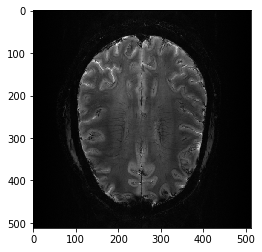

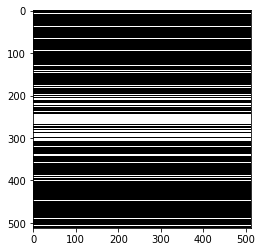

In [2]:
cartesian_ref_image = get_sample_data('2d-pmri')
cartesian_ref_image = get_sample_data('2d-pmri')
cartesian_ref_image = np.sum(np.reshape(cartesian_ref_image,(8,4,512,512)), axis=0)
image = pysap.Image(data=np.sqrt(np.sum(cartesian_ref_image**2, axis=0)))
# Obtain MRI non-cartesian mask
mask = get_sample_data("cartesian-mri-mask")
kspace_loc = convert_mask_to_locations(mask.data)
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

In [3]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(samples=kspace_loc, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

/home/chaithyagr/Codes/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


Zero Filled reconstruction

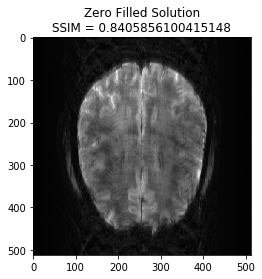

In [4]:
zero_filled = fourier_op.adj_op(kspace_obs)
image_rec0 = pysap.Image(data=np.sqrt(np.sum(np.abs(zero_filled)**2, axis=0)))
# image_rec0.show()
base_ssim = ssim(image_rec0, image)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()

 
Setup the operators for reconstruction
--------------------------------------

Linear Operator : Symlet 8 with 4 scales

In [5]:
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)

Regularizer : Group LASSO Norm with lambda = 6e-8

In [6]:
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = OWL(
    alpha=1.05e-8,
    beta=0,
    mode='band_based',
    n_coils=cartesian_ref_image.shape[0],
    bands_shape=linear_op.coeffs_shape,
)

### Setup Reconstructor:
Setup a calibrationless reconstructor

In [11]:
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000000545
The lipschitz constraint is satisfied


FISTA optimization
------------------
We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

 - mu:  [<modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd4e0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cdb38>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cdb00>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd908>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cde48>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd860>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cdbe0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cdd30>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cdeb8>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cda58>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd358>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd198>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x7f7ab60cd4a8>]
 - lipschitz constant:  1.1000000000000545
 - data:  (512, 512)
 - w

100% (100 of 100) |######################| Elapsed Time: 0:01:30 Time:  0:01:30


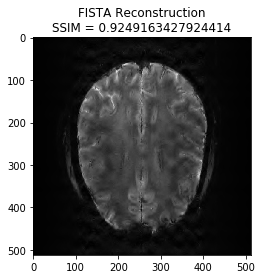

In [12]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = pysap.Image(data=np.sqrt(np.sum(np.abs(x_final)**2, axis=0)))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
